In [1]:
from math import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from scipy.interpolate import lagrange
from scipy.optimize import curve_fit
import re
from scipy.stats import boxcox, ttest_ind
from scipy.stats import rv_histogram
import scipy.stats as stats
from scipy.special import inv_boxcox
import statsmodels as sm
import sklearn as sk
from sklearn.preprocessing import power_transform
from multiprocessing import Pool
from mpl_toolkits.basemap import Basemap as Basemap
import mplleaflet

#network analysis packages
import networkx as nx
import community
from community import community_louvain
from networkx.algorithms.community import greedy_modularity_communities
import warnings
from matplotlib.collections import LineCollection
from geopy.distance import distance


from datetime import datetime, timedelta
warnings.filterwarnings('ignore')


# 1. Read in commuting data, filter by feasibility, assign counties to airports

Here we filter commuting data by feasibility for an electric aircraft (range, number of flows).

In [2]:
commuting_flows = pd.read_csv('Save Points/ca_flows_df.csv')
commuting_flows = commuting_flows.dropna()

In [3]:
distances = []
for ii in commuting_flows.index:
    o = (commuting_flows['Origin Lat'][ii], commuting_flows['Origin Lon'][ii])
    d = (commuting_flows['Dest Lat'][ii], commuting_flows['Dest Lon'][ii])
    dist = distance(o, d).mi
    distances.append(dist)

In [4]:
commuting_flows['Distance (mi)'] = distances
#filter out infeasible routes (> 506 miles, < 108 passengers 
commuting_flows_fltr = commuting_flows[commuting_flows['Distance (mi)'] < 500]
commuting_flows_fltr = commuting_flows_fltr[commuting_flows_fltr['Flow'] > 9 * 12 * 6]
commuting_flows_fltr = commuting_flows_fltr[commuting_flows_fltr['Origin'] != commuting_flows_fltr['Destination']]



In [5]:
county_location_dict = {}
for jj in commuting_flows_fltr.index:
    label = commuting_flows_fltr['Origin'][jj]
    lat = commuting_flows_fltr['Origin Lat'][jj]
    lon = commuting_flows_fltr['Origin Lon'][jj]*-1
    county_location_dict[label] = (lat, lon)

for kk in commuting_flows_fltr.index:
    label = commuting_flows_fltr['Destination'][jj]
    lat = commuting_flows_fltr['Dest Lat'][jj]
    lon = commuting_flows_fltr['Dest Lon'][jj]*-1
    county_location_dict[label] = (lat, lon)

In [6]:
county_location_dict

{'Alameda County': (37.648081, -121.91330400000001),
 'Amador County': (38.44355, -120.653856),
 'Butte County': (39.665959, -121.601919),
 'Calaveras County': (38.187844, -120.55511499999999),
 'Clark County': (36.214236, -115.013819),
 'Colusa County': (39.177739, -122.237563),
 'Contra Costa County': (37.919478999999995, -121.95154299999999),
 'Douglas County': (38.905128999999995, -119.60901899999999),
 'El Dorado County': (38.785532, -120.534398),
 'Fresno County': (36.761006, -119.655019),
 'Glenn County': (39.602546000000004, -122.4017),
 'Imperial County': (33.040816, -115.355395),
 'Kern County': (35.346629, -118.729506),
 'Kings County': (36.072478000000004, -119.81553000000001),
 'Lake County': (39.094802, -122.746757),
 'Los Angeles County': (34.196397999999995, -118.26186200000001),
 'Madera County': (37.210039, -119.749852),
 'Maricopa County': (33.346540999999995, -112.495534),
 'Marin County': (38.051817, -122.745974),
 'Mendocino County': (39.432388, -123.442881),
 'Me

In [7]:
ca_airports = pd.read_csv('CA_airports.csv')
ca_airports = ca_airports[['AIRPORTID', 'LATDD', 'LONGDD']]

In [8]:
assigned_airport = {}
for key in county_location_dict:
    distances_array = []
    county_coords = county_location_dict[key]
    for idx in ca_airports.index:
        airport_coords = (ca_airports['LATDD'][idx], ca_airports['LONGDD'][idx])
        current_distance = distance(county_coords, airport_coords).miles
        distances_array.append(current_distance)
    assigned_airport[key] = np.argmin(distances_array)

In [9]:
assigned_airport_mapping = {}
for key in assigned_airport:
    assigned_airport_mapping[key] = ca_airports.iloc[assigned_airport[key]]['AIRPORTID']

In [10]:
assigned_airport_mapping['Tuolumne County'] = 'O22'
assigned_airport_mapping['Lassen County'] = 'O39'

In [11]:
commuting_flows_fltr['Origin Airport'] = commuting_flows_fltr['Origin'].map(assigned_airport_mapping)
commuting_flows_fltr['Dest Airport'] = commuting_flows_fltr['Destination'].map(assigned_airport_mapping)



# 2. Calculate Alice Emissions for each flow

In [12]:
electric_aircraft_df = commuting_flows_fltr[['Origin', 'Destination', 'Flow', 'Distance (mi)', 
                                            'Origin Airport', 'Dest Airport']]

In [13]:
electric_aircraft_df['Commuting CO2 (kg)'] = electric_aircraft_df['Flow'] * electric_aircraft_df['Distance (mi)'] * (0.23175)



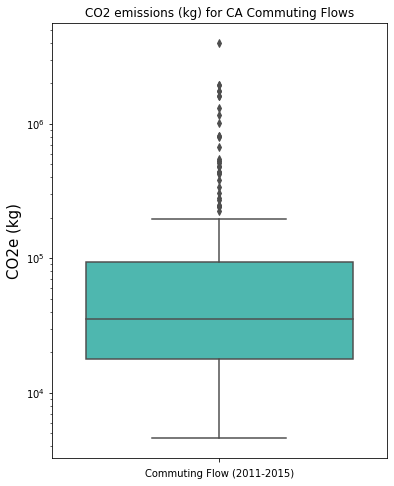

In [14]:
fig, ax = plt.subplots(figsize = (6,8))
sns.boxplot(y = 'Commuting CO2 (kg)', data = electric_aircraft_df, color = '#3cc9be')
ax.set_yscale('log')
ax.set_ylabel('CO2e (kg)', fontsize = 15);
ax.set_xlabel('Commuting Flow (2011-2015)');
ax.set_title('CO2 emissions (kg) for CA Commuting Flows')
plt.show()

In [15]:
ef_airports = pd.read_csv('airport_emission_factors.csv')[['Dep. Airports', 'Emissions Factor']]
ef_airports_dict = ef_airports.set_index('Dep. Airports').to_dict()['Emissions Factor']
electric_aircraft_df['Alice Frequency'] = np.ceil(electric_aircraft_df['Flow'] / 9)
electric_aircraft_df['EF Airport'] = electric_aircraft_df['Origin Airport'].map(ef_airports_dict)
electric_aircraft_df['EA Emissions'] = electric_aircraft_df['Alice Frequency'] * (electric_aircraft_df['EF Airport'] / 1000) * 1.621 * electric_aircraft_df['Distance (mi)']



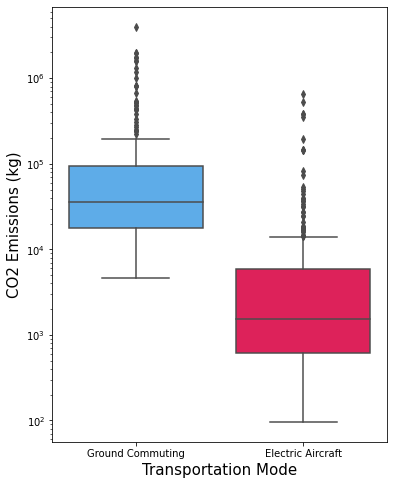

In [16]:
comp_table = electric_aircraft_df[['Commuting CO2 (kg)', 'EA Emissions']]
comp_table = comp_table.rename(columns = {'Commuting CO2 (kg)': 'Ground Commuting', 'EA Emissions': 'Electric Aircraft'})



fig, ax = plt.subplots(figsize = (6,8))
set_color = {'Ground Commuting': '#47afff', 'Electric Aircraft': '#fc034e'}
ax = sns.boxplot(x = 'variable', y = "value", data = pd.melt(comp_table),
                     palette = set_color)
ax.set_yscale('log');
ax.set_ylabel('CO2 Emissions (kg)', fontsize = 15);
ax.set_xlabel('Transportation Mode', fontsize = 15);
plt.savefig('Presentation Figures/emission_comparison.png', transparent = False, bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)



In [17]:
sens_analysis_df = electric_aircraft_df[['Origin', 'Destination', 'Flow', 'Distance (mi)', 
                                         'Commuting CO2 (kg)', 'EF Airport', 'EA Emissions']]
sens_analysis_df = sens_analysis_df.sort_values('Flow', ascending = False).head(6)

In [18]:
sens_analysis_df

,Origin,Destination,Flow,Distance (mi),Commuting CO2 (kg),EF Airport,EA Emissions
2455,Los Angeles County,Orange County,185878.0,45.422707,1.956684e+06,426.8,649059.645626
3435,Orange County,Los Angeles County,185058.0,45.422707,1.948052e+06,129.8,196515.165822
4351,San Bernardino County,Los Angeles County,135859.0,127.135146,4.002891e+06,17.4,54132.710750
745,Contra Costa County,Alameda County,100160.0,18.834297,4.371832e+05,43.6,14814.092671
4017,Riverside County,San Bernardino County,97000.0,78.379497,1.761952e+06,280.9,384658.564011
108,Alameda County,San Francisco County,92246.0,61.567310,1.316187e+06,43.6,44600.892268


In [19]:
def calculate_ea_emissions(switch_percent):
    flow = sens_analysis_df['Flow'] * switch_percent
    flights = np.ceil(flow /  9)
    ea_emissions = flights * (sens_analysis_df['EF Airport'] / 1000) * 1.621 * sens_analysis_df['Distance (mi)']
    leftover_emissions = sens_analysis_df['Commuting CO2 (kg)'] * (1 - switch_percent)
    percent_reduction = 1 - ((ea_emissions + leftover_emissions) / sens_analysis_df['Commuting CO2 (kg)'])
    return percent_reduction * 100

In [20]:
# note: for future considerations, add using survey data to see what percentage of people might shift from
# private vehicle to electric aircraft to get better estimates of GHG emission reductions

percentages = [0.01, 0.1, 0.25]
for percent in percentages:
    col_name = str(percent)
    sens_analysis_df[col_name] = calculate_ea_emissions(percent)

In [21]:
def OD_pairs(origin, dest):
    orig = re.search('.+(?= County)', origin)[0]
    dest = re.search('.+(?= County)', dest)[0]
    return orig + ' - ' + dest

In [22]:
sens_analysis_df['OD'] = np.nan
for idx in sens_analysis_df.index:
    origin = sens_analysis_df['Origin'][idx]
    dest = sens_analysis_df['Destination'][idx]
    OD_pair = OD_pairs(origin, dest)
    sens_analysis_df['OD'][idx] = OD_pair 
sens_analysis_df = sens_analysis_df.set_index('OD')

In [23]:
barplot_df = sens_analysis_df[['0.01', '0.1', '0.25']].T
np.array(barplot_df.loc['0.1'])

array([6.68189589, 8.99082986, 9.86473014, 9.66111635, 7.81645555,
       9.66113549])

In [24]:
barplot_df

OD,Los Angeles - Orange,Orange - Los Angeles,San Bernardino - Los Angeles,Contra Costa - Alameda,Riverside - San Bernardino,Alameda - San Francisco
0.01,0.667547,0.898936,0.986473,0.965899,0.781240,0.965948
0.1,6.681896,8.990830,9.864730,9.661116,7.816456,9.661135
0.25,16.706346,22.477811,24.661915,24.152639,19.541139,24.152673


In [25]:
ul = np.array(barplot_df.loc['0.25']) - np.array(barplot_df.loc['0.1'])
ll = np.array(barplot_df.loc['0.1'] - np.array(barplot_df.loc['0.01']))

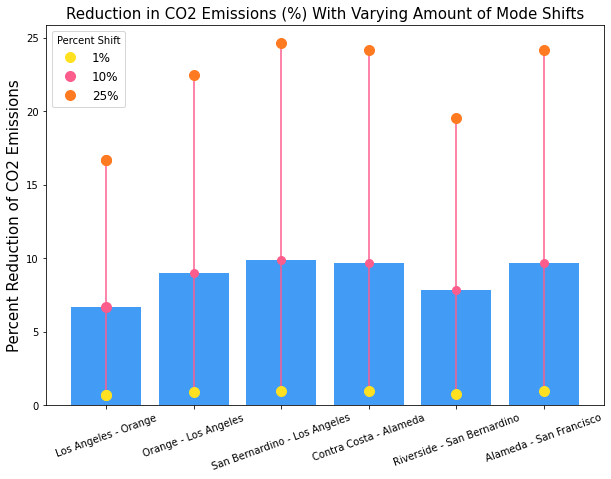

In [26]:
#plotting emission reduction for mode shifts
x_pos = np.arange(len(sens_analysis_df))
labels = list(sens_analysis_df.index)
reductions = np.array(barplot_df.loc['0.1'])
fig, ax = plt.subplots(figsize = (10, 7));
ax.bar(x_pos, reductions, color = '#429bf5');
ax.set_xticks(x_pos);
ax.set_xticklabels(labels, rotation = 20);
ax.errorbar(x_pos, reductions, yerr = (ll, ul), color = '#fc5d8d', capsize=5, capthick=2, fmt = 'o',
            markersize = 8);

for ii in range(len(x_pos)):
    if ii == 0:
        ax.plot(x_pos[ii], -1 * (ll[ii] - barplot_df.iloc[1, ii]), 'o', markersize = 10, 
                color = '#ffe121', label = '1%')
        
        ax.plot(x_pos[ii], barplot_df.iloc[1, ii], 'o', markersize = 10, color = '#fc5d8d', label = '10%')

        ax.plot(x_pos[ii], ul[ii] + barplot_df.iloc[1, ii], 'o', markersize = 10, color = '#ff7a21', label = '25%')
        
    ax.plot(x_pos[ii], ul[ii] + barplot_df.iloc[1, ii], 'o', markersize = 10, color = '#ff7a21')
    ax.plot(x_pos[ii], -1* (ll[ii] - barplot_df.iloc[1, ii]), 'o', markersize = 10, color = '#ffe121')
    
ax.set_ylabel('Percent Reduction of CO2 Emissions', fontsize = 15);
ax.set_title('Reduction in CO2 Emissions (%) With Varying Amount of Mode Shifts', fontsize = 15);
ax.legend(['1%', '10%', '25%'], title = 'Percent Shift', fontsize = 12);
#plt.savefig('Presentation Figures/sens_analysis_fig.png', transparent = False, bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)


In [27]:
electric_aircraft_df.sort_values('Flow', ascending = False).tail(6)

,Origin,Destination,Flow,Distance (mi),Origin Airport,Dest Airport,Commuting CO2 (kg),Alice Frequency,EF Airport,EA Emissions
4231,Sacramento County,Stanislaus County,666.0,63.934584,MHR,MOD,9868.015294,74.0,195.3,1497.796529
2407,Los Angeles County,Maricopa County,662.0,336.980435,BUR,BLH,51699.032927,74.0,426.8,17252.174109
5753,Tehama County,Glenn County,659.0,37.231006,RBL,WLW,5686.040268,74.0,43.6,194.717954
3364,Orange County,Clark County,659.0,234.978476,SNA,L61,35886.676611,74.0,129.8,3658.621740
446,Butte County,Sacramento County,651.0,85.049757,OVE,MHR,12831.393028,73.0,43.6,438.798809
2492,Los Angeles County,Sacramento County,651.0,339.831884,BUR,MHR,51270.181472,73.0,426.8,17163.047680


# 4. Three-pronged comparison: ticket vs fuel costs, travel times, CO2 emissions

In [28]:
electric_aircraft_df

,Origin,Destination,Flow,Distance (mi),Origin Airport,Dest Airport,Commuting CO2 (kg),Alice Frequency,EF Airport,EA Emissions
36,Alameda County,Contra Costa County,41010.0,18.834297,LVK,CCR,1.790024e+05,4557.0,43.6,6065.937668
74,Alameda County,Los Angeles County,732.0,313.892720,LVK,BUR,5.324907e+04,82.0,43.6,1819.133619
77,Alameda County,Marin County,4823.0,53.375047,LVK,DVO,5.965890e+04,536.0,43.6,2021.960030
103,Alameda County,Sacramento County,899.0,63.523958,LVK,MHR,1.323479e+04,100.0,43.6,448.959387
108,Alameda County,San Francisco County,92246.0,61.567310,LVK,HAF,1.316187e+06,10250.0,43.6,44600.892268
...,...,...,...,...,...,...,...,...,...,...
6354,Yuba County,Nevada County,869.0,30.652910,MYV,BLU,6.173213e+03,97.0,43.6,210.142045
6355,Yuba County,Placer County,2488.0,36.331707,MYV,E36,2.094864e+04,277.0,43.6,711.270955
6357,Yuba County,Sacramento County,2800.0,56.565149,MYV,MHR,3.670513e+04,312.0,43.6,1247.306073
6370,Yuba County,Sutter County,4803.0,25.159729,MYV,O52,2.800518e+04,534.0,43.6,949.547573


In [29]:
### ticket costs for Eviation Alice ###

# operating cost of Alice is $350 per hour, according to CEO of Eviation
# operating cost (Geography of Transport Systems) include crew, fuel, maintenance, depreciation, etc
ea_operation = 350 #USD per hour

# flight time = taxi out, takeoff, climbout, approach, landing, taxi in
#LTO times: https://www.eurocontrol.int/sites/default/files/2019-03/emep-eea-air-pollution-emission-inventory-method-v1.0.pdf

LTO_time = (1140 + 42 + 132 + 200 + 40 + 420) / 3600;
cruise_time = electric_aircraft_df['Distance (mi)'] * (1/287) # [1 hr/miles]
total_flight_time = LTO_time + cruise_time

# potential ticket costs (taxes from https://taxfoundation.org/understanding-the-price-of-your-plane-ticket/)
ea_baseline_cost = ((ea_operation * total_flight_time) / 9)
ea_with_taxes = ea_baseline_cost + (ea_baseline_cost * 0.075) + 4.2 + 5.6 + (4.5 * 2)
ea_full_ticket = ea_with_taxes * 1.1 #10% profit margin 

# fuel costs (lower estimate and upper estimate): 
# https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=pet&s=emm_epm0_pte_sca_dpg&f=m
fuel_economy = 24 # [mpg]
gas_low = 3.35 #[USD/gallon]
gas_high = 4.6 #[USD/gallon]
fuel_cost_lowest = electric_aircraft_df['Distance (mi)'] * (1 / fuel_economy) * gas_low
fuel_cost_highest = electric_aircraft_df['Distance (mi)'] * (1 / fuel_economy) * gas_high


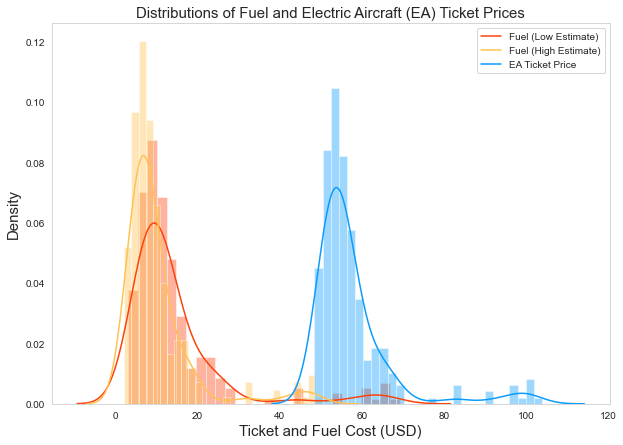

In [251]:
plt.subplots(figsize = (10, 7))
sns.distplot(fuel_cost_highest, color = '#fc420a') 
sns.distplot(fuel_cost_lowest, color = '#ffc252')
sns.distplot(ea_full_ticket, color = '#0a9bfc')
plt.xlabel('Ticket and Fuel Cost (USD)', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.title('Distributions of Fuel and Electric Aircraft (EA) Ticket Prices', fontsize = 15);
plt.legend(['Fuel (Low Estimate)', 'Fuel (High Estimate)', 'EA Ticket Price'])
plt.savefig('Presentation Figures/price_comparison.png', transparent = False, bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)
plt.show()



In [31]:
# CO2 emissions

In [32]:
commuting_flows_fltr['Origin Lon'] *= -1
commuting_flows_fltr['Dest Lon'] *= -1

In [33]:
commuting_flows_fltr

,Origin,Destination,Origin State,Destination State,Flow,Error,Origin Lat,Origin Lon,Dest Lat,Dest Lon,Distance (mi),Origin Airport,Dest Airport
36,Alameda County,Contra Costa County,California,California,41010.0,1304.0,37.648081,-121.913304,37.919479,-121.951543,18.834297,LVK,CCR
74,Alameda County,Los Angeles County,California,California,732.0,181.0,37.648081,-121.913304,34.196398,-118.261862,313.892720,LVK,BUR
77,Alameda County,Marin County,California,California,4823.0,444.0,37.648081,-121.913304,38.051817,-122.745974,53.375047,LVK,DVO
103,Alameda County,Sacramento County,California,California,899.0,222.0,37.648081,-121.913304,38.450011,-121.340441,63.523958,LVK,MHR
108,Alameda County,San Francisco County,California,California,92246.0,2228.0,37.648081,-121.913304,37.727239,-123.032229,61.567310,LVK,HAF
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6354,Yuba County,Nevada County,California,California,869.0,235.0,39.270026,-121.344280,39.295191,-120.773446,30.652910,MYV,BLU
6355,Yuba County,Placer County,California,California,2488.0,390.0,39.270026,-121.344280,39.062032,-120.722718,36.331707,MYV,E36
6357,Yuba County,Sacramento County,California,California,2800.0,411.0,39.270026,-121.344280,38.450011,-121.340441,56.565149,MYV,MHR
6370,Yuba County,Sutter County,California,California,4803.0,503.0,39.270026,-121.344280,39.035257,-121.702758,25.159729,MYV,O52


In [34]:
ca_airports

,AIRPORTID,LATDD,LONGDD
0,A26,41.186500,-120.954389
1,L54,32.955694,-116.294722
2,L70,34.502569,-118.314644
3,M45,38.734750,-119.767056
4,AAT,41.482972,-120.565389
...,...,...,...
237,O42,36.398778,-119.106806
238,DWA,38.579389,-121.856944
239,MYV,39.097778,-121.569833
240,L22,34.129833,-116.406889


In [35]:
# Travel times: use BingMaps API Key

import urllib.request
import json

#this uses the Bing Maps API key, so avoid running if necessary (247 API calls)

#Bing Maps Key:
api_key = 'api_key_here';

counter = 0;

driving_distances = [];
driving_times = [];


for idx in commuting_flows_fltr.index:
    print(counter)
    origin = str(commuting_flows_fltr['Origin Lat'][idx]) + ',' + str(commuting_flows_fltr['Origin Lon'][idx])
    dest = str(commuting_flows_fltr['Dest Lat'][idx]) + ',' + str(commuting_flows_fltr['Dest Lon'][idx])
    
    #build full URL request:
    OD_url = 'https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=' + origin + '&destinations=' + dest + '&travelMode=driving&key=' + api_key;
    request = urllib.request.Request(OD_url)
    response = urllib.request.urlopen(request)
    
    #read response
    r = response.read().decode(encoding = "utf-8")
    result = json.loads(r)
    
    #results:
    travelDurations = result["resourceSets"][0]["resources"][0]["results"][0]['travelDuration']
    travelDistance = result["resourceSets"][0]["resources"][0]["results"][0]['travelDistance']
    
    #append results:
    driving_distances.append(travelDistance)
    driving_times.append(travelDurations)
    
    counter += 1
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246


In [36]:
driving_times

[46.55,
 297.9167,
 82.4167,
 88.35,
 131.1,
 52.2833,
 71.1167,
 53.7333,
 62.6833,
 109.95,
 69.4667,
 71.7833,
 109.3,
 74.0333,
 66.7833,
 63.7333,
 64.1167,
 72.7667,
 177.6333,
 261.9667,
 205.7333,
 44.0833,
 50.7333,
 333.8333,
 94.6667,
 96.2,
 106.2,
 144.15,
 75.5833,
 103.4833,
 95.15,
 67.25,
 121.9833,
 82.3,
 113.6333,
 113.7667,
 112.4833,
 75.9667,
 101.3333,
 123.65,
 67.3167,
 200.3667,
 50.9,
 86.3167,
 118.6,
 104.25,
 71.4833,
 116.45,
 129.8667,
 123.3,
 179.5167,
 107.65,
 67.9333,
 123.8333,
 109.7167,
 104.4333,
 101.3,
 122.7667,
 300.45,
 260.7,
 123.7167,
 320.2833,
 66.05,
 165.55,
 323.4,
 184.1333,
 160.6,
 414.7333,
 352.4167,
 136.0667,
 301.6333,
 95.3,
 51.0667,
 101.0667,
 320.65,
 79.85,
 89.2333,
 49.9167,
 107.0333,
 116.2,
 74.9,
 125.3,
 114.5833,
 88.1333,
 104.6667,
 109.7167,
 96.2333,
 115.4333,
 69.4833,
 299.7333,
 116.1667,
 111.3333,
 104.7833,
 96.2,
 92.0333,
 94.5667,
 104.1667,
 149.1,
 63.05,
 86.5,
 92.7333,
 97.9833,
 271.3667,
 

In [37]:
driving_df = commuting_flows_fltr[['Origin', 'Destination', 'Flow', 'Origin Lat', 'Origin Lon', 'Dest Lat', 'Dest Lon', 'Origin Airport', 'Dest Airport']]
driving_df['Travel Time (hr)'] = np.array(driving_times) / 60;
driving_df['Driving Dist (mi)'] = np.array(driving_distances) / 1.609; # convert from km to miles


In [38]:
driving_df

,Origin,Destination,Flow,Origin Lat,Origin Lon,Dest Lat,Dest Lon,Origin Airport,Dest Airport,Travel Time (hr),Driving Dist (mi)
36,Alameda County,Contra Costa County,41010.0,37.648081,-121.913304,37.919479,-121.951543,LVK,CCR,0.775833,31.574891
74,Alameda County,Los Angeles County,732.0,37.648081,-121.913304,34.196398,-118.261862,LVK,BUR,4.965278,347.518956
77,Alameda County,Marin County,4823.0,37.648081,-121.913304,38.051817,-122.745974,LVK,DVO,1.373612,65.857054
103,Alameda County,Sacramento County,899.0,37.648081,-121.913304,38.450011,-121.340441,LVK,MHR,1.472500,90.778123
108,Alameda County,San Francisco County,92246.0,37.648081,-121.913304,37.727239,-123.032229,LVK,HAF,2.185000,89.277812
...,...,...,...,...,...,...,...,...,...,...,...
6354,Yuba County,Nevada County,869.0,39.270026,-121.344280,39.295191,-120.773446,MYV,BLU,0.971388,42.191423
6355,Yuba County,Placer County,2488.0,39.270026,-121.344280,39.062032,-120.722718,MYV,E36,1.716112,69.133623
6357,Yuba County,Sacramento County,2800.0,39.270026,-121.344280,38.450011,-121.340441,MYV,MHR,1.460555,74.810441
6370,Yuba County,Sutter County,4803.0,39.270026,-121.344280,39.035257,-121.702758,MYV,O52,0.920833,32.551896


In [39]:
#calculate airport commute
od_pair_aircraft = commuting_flows_fltr[['Origin Airport', 'Dest Airport']]

In [40]:
f_merge = od_pair_aircraft.merge(ca_airports, left_on = 'Origin Airport', right_on = 'AIRPORTID', how = 'left').drop('AIRPORTID', axis = 1)
f_merge = f_merge.rename(columns = {'LATDD': 'Origin Airport Lat', 'LONGDD': 'Origin Airport Lon'})

s_merge = f_merge.merge(ca_airports, left_on = 'Dest Airport', right_on = 'AIRPORTID', how = 'left').drop('AIRPORTID', axis = 1)
s_merge = s_merge.rename(columns = {'LATDD': 'Dest Airport Lat', 'LONGDD': 'Dest Airport Lon'})


In [41]:
df1 = commuting_flows_fltr[['Origin', 'Destination', 'Origin Lat', 'Origin Lon', 'Dest Lat', 'Dest Lon']]
df3 = pd.concat([df1, s_merge.set_index(df1.index)], axis = 1)
df3

,Origin,Destination,Origin Lat,Origin Lon,Dest Lat,Dest Lon,Origin Airport,Dest Airport,Origin Airport Lat,Origin Airport Lon,Dest Airport Lat,Dest Airport Lon
36,Alameda County,Contra Costa County,37.648081,-121.913304,37.919479,-121.951543,LVK,CCR,37.693389,-121.820361,37.989667,-122.056889
74,Alameda County,Los Angeles County,37.648081,-121.913304,34.196398,-118.261862,LVK,BUR,37.693389,-121.820361,34.200667,-118.358667
77,Alameda County,Marin County,37.648081,-121.913304,38.051817,-122.745974,LVK,DVO,37.693389,-121.820361,38.143611,-122.556100
103,Alameda County,Sacramento County,37.648081,-121.913304,38.450011,-121.340441,LVK,MHR,37.693389,-121.820361,38.555264,-121.297250
108,Alameda County,San Francisco County,37.648081,-121.913304,37.727239,-123.032229,LVK,HAF,37.693389,-121.820361,37.513444,-122.501167
...,...,...,...,...,...,...,...,...,...,...,...,...
6354,Yuba County,Nevada County,39.270026,-121.344280,39.295191,-120.773446,MYV,BLU,39.097778,-121.569833,39.274972,-120.709750
6355,Yuba County,Placer County,39.270026,-121.344280,39.062032,-120.722718,MYV,E36,39.097778,-121.569833,38.920972,-120.864833
6357,Yuba County,Sacramento County,39.270026,-121.344280,38.450011,-121.340441,MYV,MHR,39.097778,-121.569833,38.555264,-121.297250
6370,Yuba County,Sutter County,39.270026,-121.344280,39.035257,-121.702758,MYV,O52,39.097778,-121.569833,39.123667,-121.605361


In [42]:
api_key = 'api_key_here'

air_driving_time = []
air_driving_dist = []

counter = 0

for idx in df3.index:
    print(counter)
    
    #outgoing trip:
    outgoing_origin = str(df3['Origin Lat'][idx]) + ',' + str(df3['Origin Lon'][idx])
    outgoing_airport = str(df3['Origin Airport Lat'][idx]) + ',' + str(df3['Origin Airport Lon'][idx])
    
    #incoming trip
    incoming_airport = str(df3['Dest Airport Lat'][idx]) + ',' + str(df3['Dest Airport Lon'][idx])
    incoming_dest = str(df3['Dest Lat'][idx]) + ',' + str(df3['Dest Lon'][idx])
    
    #build URL for incoming and outgoing trips
    outgoing_url = 'https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=' + outgoing_origin + '&destinations=' + outgoing_airport + '&travelMode=driving&key=' + api_key;
    incoming_url = 'https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins=' + incoming_airport + '&destinations=' + incoming_dest + '&travelMode=driving&key=' + api_key;
    
    request_out = urllib.request.Request(outgoing_url)
    request_in = urllib.request.Request(incoming_url)
    
    response_out = urllib.request.urlopen(request_out)
    response_in = urllib.request.urlopen(request_in)
    
    #read response
    r1 = response_out.read().decode(encoding = "utf-8")
    result1 = json.loads(r1)
    
    r2 = response_in.read().decode(encoding = "utf-8")
    result2 = json.loads(r2)
    
    #results:
    travel_time = result1["resourceSets"][0]["resources"][0]["results"][0]['travelDuration'] + result2["resourceSets"][0]["resources"][0]["results"][0]['travelDuration']
    travel_dist = result1["resourceSets"][0]["resources"][0]["results"][0]['travelDistance'] + result2["resourceSets"][0]["resources"][0]["results"][0]['travelDistance']
    
    air_driving_time.append(travel_time)
    air_driving_dist.append(travel_dist)
    
    counter += 1
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246


In [43]:
aircraft_travel_df = df3[['Origin', 'Origin Airport', 'Dest Airport', 'Destination']]
aircraft_travel_df['Driving Time (hr)'] = np.array(air_driving_time) / 60 #hours
aircraft_travel_df['Driving Distance (mi)'] = np.array(air_driving_dist) / 1.609 #miles
aircraft_travel_df

,Origin,Origin Airport,Dest Airport,Destination,Driving Time (hr),Driving Distance (mi)
36,Alameda County,LVK,CCR,Contra Costa County,0.821667,25.506526
74,Alameda County,LVK,BUR,Los Angeles County,0.710833,23.214419
77,Alameda County,LVK,DVO,Marin County,0.806112,31.431945
103,Alameda County,LVK,MHR,Sacramento County,0.603612,20.805469
108,Alameda County,LVK,HAF,San Francisco County,2.456667,86.364201
...,...,...,...,...,...,...
6354,Yuba County,MYV,BLU,Nevada County,1.070833,41.955873
6355,Yuba County,MYV,E36,Placer County,1.810277,64.452455
6357,Yuba County,MYV,MHR,Sacramento County,1.016388,32.691734
6370,Yuba County,MYV,O52,Sutter County,1.044443,34.707893


In [44]:
air_distances = []
for dd in df3.index:
    o = (df3['Origin Airport Lat'][dd], df3['Origin Airport Lon'][dd])
    d = (df3['Dest Airport Lat'][dd], df3['Dest Airport Lon'][dd])
    air_dist = distance(o, d).mi
    air_distances.append(air_dist)

In [45]:
aircraft_travel_df['Flying Distance (mi)'] = air_distances
aircraft_travel_df['Flying Time (hr)'] = np.array(air_distances) * (1 / 287)
aircraft_travel_df['Total Travel Time'] = aircraft_travel_df['Flying Time (hr)'] + aircraft_travel_df['Driving Time (hr)']



In [46]:
aircraft_travel_df

,Origin,Origin Airport,Dest Airport,Destination,Driving Time (hr),Driving Distance (mi),Flying Distance (mi),Flying Time (hr),Total Travel Time
36,Alameda County,LVK,CCR,Contra Costa County,0.821667,25.506526,24.184557,0.084267,0.905933
74,Alameda County,LVK,BUR,Los Angeles County,0.710833,23.214419,309.223320,1.077433,1.788267
77,Alameda County,LVK,DVO,Marin County,0.806112,31.431945,50.794452,0.176984,0.983096
103,Alameda County,LVK,MHR,Sacramento County,0.603612,20.805469,65.923923,0.229700,0.833312
108,Alameda County,LVK,HAF,San Francisco County,2.456667,86.364201,39.362582,0.137152,2.593819
...,...,...,...,...,...,...,...,...,...
6354,Yuba County,MYV,BLU,Nevada County,1.070833,41.955873,47.764458,0.166427,1.237260
6355,Yuba County,MYV,E36,Placer County,1.810277,64.452455,39.855031,0.138868,1.949144
6357,Yuba County,MYV,MHR,Sacramento County,1.016388,32.691734,40.209039,0.140101,1.156490
6370,Yuba County,MYV,O52,Sutter County,1.044443,34.707893,2.614424,0.009109,1.053553


In [47]:
driving_df

,Origin,Destination,Flow,Origin Lat,Origin Lon,Dest Lat,Dest Lon,Origin Airport,Dest Airport,Travel Time (hr),Driving Dist (mi)
36,Alameda County,Contra Costa County,41010.0,37.648081,-121.913304,37.919479,-121.951543,LVK,CCR,0.775833,31.574891
74,Alameda County,Los Angeles County,732.0,37.648081,-121.913304,34.196398,-118.261862,LVK,BUR,4.965278,347.518956
77,Alameda County,Marin County,4823.0,37.648081,-121.913304,38.051817,-122.745974,LVK,DVO,1.373612,65.857054
103,Alameda County,Sacramento County,899.0,37.648081,-121.913304,38.450011,-121.340441,LVK,MHR,1.472500,90.778123
108,Alameda County,San Francisco County,92246.0,37.648081,-121.913304,37.727239,-123.032229,LVK,HAF,2.185000,89.277812
...,...,...,...,...,...,...,...,...,...,...,...
6354,Yuba County,Nevada County,869.0,39.270026,-121.344280,39.295191,-120.773446,MYV,BLU,0.971388,42.191423
6355,Yuba County,Placer County,2488.0,39.270026,-121.344280,39.062032,-120.722718,MYV,E36,1.716112,69.133623
6357,Yuba County,Sacramento County,2800.0,39.270026,-121.344280,38.450011,-121.340441,MYV,MHR,1.460555,74.810441
6370,Yuba County,Sutter County,4803.0,39.270026,-121.344280,39.035257,-121.702758,MYV,O52,0.920833,32.551896


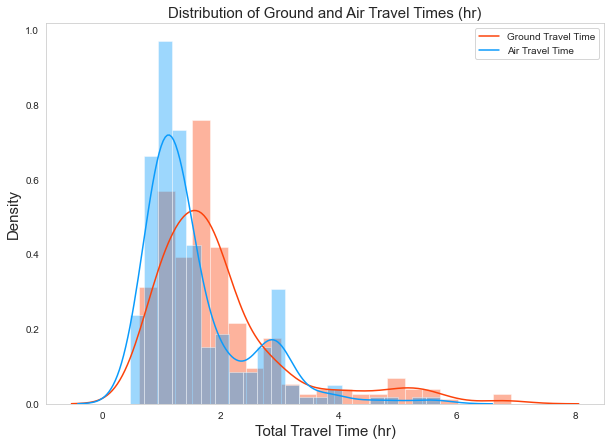

In [167]:
plt.subplots(figsize = (10, 7)) 
sns.distplot(driving_df['Travel Time (hr)'], color = '#fc420a')
sns.distplot(aircraft_travel_df['Total Travel Time'], color = '#0a9bfc')
plt.legend(['Ground Travel Time', 'Air Travel Time'])
plt.ylabel('Density', fontsize = 15)
plt.xlabel('Total Travel Time (hr)', fontsize = 15)
plt.title('Distribution of Ground and Air Travel Times (hr)', fontsize = 15)
plt.savefig('Presentation Figures/travel_time_comparison.png', transparent = False, bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)
plt.show()

In [49]:
air_CO2 = (electric_aircraft_df['EF Airport'] / 1000) * 1.621 * aircraft_travel_df['Flying Distance (mi)'] * (1/9)
drive_CO2 = aircraft_travel_df['Driving Distance (mi)'] * 0.23175
aircraft_travel_df['Total Emissions (kg CO2e)'] = air_CO2 + drive_CO2

aircraft_travel_df['EA Ticket (USD)'] = ea_full_ticket


In [50]:
aircraft_travel_df

,Origin,Origin Airport,Dest Airport,Destination,Driving Time (hr),Driving Distance (mi),Flying Distance (mi),Flying Time (hr),Total Travel Time,Total Emissions (kg CO2e),EA Ticket (USD)
36,Alameda County,LVK,CCR,Contra Costa County,0.821667,25.506526,24.184557,0.084267,0.905933,6.101055,48.913544
74,Alameda County,LVK,BUR,Los Angeles County,0.710833,23.214419,309.223320,1.077433,1.788267,7.808224,96.190859
77,Alameda County,LVK,DVO,Marin County,0.806112,31.431945,50.794452,0.176984,0.983096,7.683234,54.448020
103,Alameda County,LVK,MHR,Sacramento County,0.603612,20.805469,65.923923,0.229700,0.833312,5.339358,56.074184
108,Alameda County,LVK,HAF,San Francisco County,2.456667,86.364201,39.362582,0.137152,2.593819,20.324012,55.760669
...,...,...,...,...,...,...,...,...,...,...,...
6354,Yuba County,MYV,BLU,Nevada County,1.070833,41.955873,47.764458,0.166427,1.237260,10.098360,50.807244
6355,Yuba County,MYV,E36,Placer County,1.810277,64.452455,39.855031,0.138868,1.949144,15.249832,51.717160
6357,Yuba County,MYV,MHR,Sacramento County,1.016388,32.691734,40.209039,0.140101,1.156490,7.892065,54.959171
6370,Yuba County,MYV,O52,Sutter County,1.044443,34.707893,2.614424,0.009109,1.053553,8.064085,49.927070


In [51]:
ground_travel_df = electric_aircraft_df[['Origin', 'Destination', 'Flow', 'Distance (mi)', 'Commuting CO2 (kg)']]
ground_travel_df['Commuting CO2 (kg)'] = ground_travel_df['Commuting CO2 (kg)'] / ground_travel_df['Flow']
ground_travel_df['Distance (mi)'] = driving_df['Driving Dist (mi)']
ground_travel_df['Travel Time (hr)'] = driving_df['Travel Time (hr)']
ground_travel_df['Fuel Low Est (USD)'] = fuel_cost_lowest
ground_travel_df['Fuel High Est (USD)'] = fuel_cost_highest


In [52]:
ground_travel_df

,Origin,Destination,Flow,Distance (mi),Commuting CO2 (kg),Travel Time (hr),Fuel Low Est (USD),Fuel High Est (USD)
36,Alameda County,Contra Costa County,41010.0,31.574891,4.364848,0.775833,2.628954,3.609907
74,Alameda County,Los Angeles County,732.0,347.518956,72.744638,4.965278,43.814192,60.162771
77,Alameda County,Marin County,4823.0,65.857054,12.369667,1.373612,7.450267,10.230217
103,Alameda County,Sacramento County,899.0,90.778123,14.721677,1.472500,8.866886,12.175425
108,Alameda County,San Francisco County,92246.0,89.277812,14.268224,2.185000,8.593770,11.800401
...,...,...,...,...,...,...,...,...
6354,Yuba County,Nevada County,869.0,42.191423,7.103812,0.971388,4.278635,5.875141
6355,Yuba County,Placer County,2488.0,69.133623,8.419873,1.716112,5.071301,6.963577
6357,Yuba County,Sacramento County,2800.0,74.810441,13.108973,1.460555,7.895552,10.841654
6370,Yuba County,Sutter County,4803.0,32.551896,5.830767,0.920833,3.511879,4.822281


In [53]:
aircraft_travel_df[(aircraft_travel_df['Total Travel Time'] < ground_travel_df['Travel Time (hr)'])]




,Origin,Origin Airport,Dest Airport,Destination,Driving Time (hr),Driving Distance (mi),Flying Distance (mi),Flying Time (hr),Total Travel Time,Total Emissions (kg CO2e),EA Ticket (USD)
74,Alameda County,LVK,BUR,Los Angeles County,0.710833,23.214419,309.223320,1.077433,1.788267,7.808224,96.190859
77,Alameda County,LVK,DVO,Marin County,0.806112,31.431945,50.794452,0.176984,0.983096,7.683234,54.448020
103,Alameda County,LVK,MHR,Sacramento County,0.603612,20.805469,65.923923,0.229700,0.833312,5.339358,56.074184
109,Alameda County,LVK,SCK,San Joaquin County,0.383890,14.564947,34.734692,0.121027,0.504917,3.648193,52.350196
111,Alameda County,LVK,SQL,San Mateo County,0.973890,37.549410,26.669238,0.092924,1.066814,8.911505,50.682615
...,...,...,...,...,...,...,...,...,...,...,...
6274,Yolo County,O41,LVK,Alameda County,0.384445,14.282163,67.684901,0.235836,0.620281,3.841410,57.292119
6309,Yolo County,O41,E36,Placer County,1.287222,44.778745,56.979952,0.198536,1.485758,10.824929,56.937850
6311,Yolo County,O41,MHR,Sacramento County,0.493333,13.018024,32.166283,0.112078,0.605411,3.269524,51.397009
6324,Yolo County,O41,VCB,Solano County,0.668333,16.223741,20.991643,0.073142,0.741475,3.924696,50.460577


In [54]:
aircraft_travel_df[(aircraft_travel_df['Total Emissions (kg CO2e)'] < ground_travel_df['Commuting CO2 (kg)'])]



,Origin,Origin Airport,Dest Airport,Destination,Driving Time (hr),Driving Distance (mi),Flying Distance (mi),Flying Time (hr),Total Travel Time,Total Emissions (kg CO2e),EA Ticket (USD)
74,Alameda County,LVK,BUR,Los Angeles County,0.710833,23.214419,309.223320,1.077433,1.788267,7.808224,96.190859
77,Alameda County,LVK,DVO,Marin County,0.806112,31.431945,50.794452,0.176984,0.983096,7.683234,54.448020
103,Alameda County,LVK,MHR,Sacramento County,0.603612,20.805469,65.923923,0.229700,0.833312,5.339358,56.074184
109,Alameda County,LVK,SCK,San Joaquin County,0.383890,14.564947,34.734692,0.121027,0.504917,3.648193,52.350196
113,Alameda County,LVK,RHV,Santa Clara County,0.763333,26.434431,24.863580,0.086633,0.849966,6.321429,51.008909
...,...,...,...,...,...,...,...,...,...,...,...
6274,Yolo County,O41,LVK,Alameda County,0.384445,14.282163,67.684901,0.235836,0.620281,3.841410,57.292119
6309,Yolo County,O41,E36,Placer County,1.287222,44.778745,56.979952,0.198536,1.485758,10.824929,56.937850
6311,Yolo County,O41,MHR,Sacramento County,0.493333,13.018024,32.166283,0.112078,0.605411,3.269524,51.397009
6324,Yolo County,O41,VCB,Solano County,0.668333,16.223741,20.991643,0.073142,0.741475,3.924696,50.460577


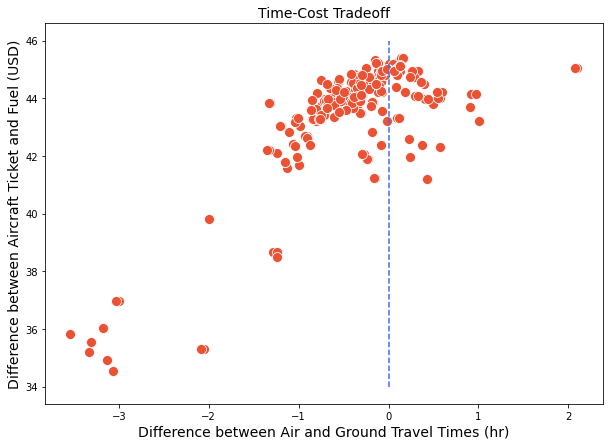

In [55]:
plt.subplots(figsize = (10, 7))
sns.scatterplot(aircraft_travel_df['Total Travel Time'] - ground_travel_df['Travel Time (hr)'], 
                aircraft_travel_df['EA Ticket (USD)'] - ground_travel_df['Fuel High Est (USD)'],
                color = '#eb5234', s = 100)
plt.vlines(0, 34, 46, linestyles = 'dashed', color = '#426cf5')
plt.ylabel('Difference between Aircraft Ticket and Fuel (USD)', fontsize = 14);
plt.xlabel('Difference between Air and Ground Travel Times (hr)', fontsize = 14);
plt.title('Time-Cost Tradeoff', fontsize = 14)
plt.savefig('Presentation Figures/time_cost_tradeoff.png', transparent = False, bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

plt.show()

# 5. Using Optimization for Route Selection: What Commuting Routes Could Benefit from Electric Aircraft?

In [ ]:
airport_new_index = []
for idx in aircraft_travel_df.index:
    new_index = aircraft_travel_df['Origin Airport'][idx] + aircraft_travel_df['Dest Airport'][idx]
    airport_new_index.append(new_index)

In [ ]:
aircraft_travel_df['OD'] = airport_new_index
aircraft_travel_df = aircraft_travel_df.set_index('OD')

In [ ]:
ground_new_index = []
for idx in ground_travel_df.index:
    new_index = OD_pairs(ground_travel_df['Origin'][idx], ground_travel_df['Destination'][idx])
    ground_new_index.append(new_index)
    
ground_travel_df['OD'] = ground_new_index
ground_travel_df = ground_travel_df.set_index('OD')

In [ ]:
ground_travel_df

In [ ]:
aircraft_travel_df

In [ ]:
((df2.iloc[0, 10] - df1.iloc[0, 6]) / (df2.iloc[0, 8] - df1.iloc[0, 5]))
 
 

In [ ]:
import gurobipy as grb

#set up optimization constraints and objective function

opt_model = grb.Model(name = 'Route Selection Opt')
#to not display optimization output:
#opt_model.Params.LogToConsole = 0

df1 = ground_travel_df
df2 = aircraft_travel_df

indices = range(len(df1))

#declare binary decision variables {0, 1}
X_vars = {idx: opt_model.addVar(vtype = grb.GRB.BINARY,
                 name = 'x_{0}'.format(idx)) for idx in indices}

Y_vars = {idx: opt_model.addVar(vtype = grb.GRB.BINARY,
                 name = 'y_{0}'.format(idx)) for idx in indices}

#ground travel coefficient

#travel time, cost, emissions
a = {idx: (1/3)*df1.iloc[idx, 5] + (1/3)*df1.iloc[idx, 6] + (1/3)*df1.iloc[idx, 4] for idx in indices}
#air travel coefficient
b = {idx: (1/3)*df2.iloc[idx, 8] + (1/3)*df2.iloc[idx, 10] + (1/3)*df2.iloc[idx, 9] for idx in indices}

#objective function
obj = grb.quicksum(X_vars[idx] * a[idx] + Y_vars[idx] * b[idx] for idx in indices)

#constraints

constr1 = {idx: opt_model.addConstr(lhs = X_vars[idx] + Y_vars[idx], 
                                    sense = grb.GRB.EQUAL,
                                    rhs = 1, 
                                    name = "constr1_{0}".format(idx)) for idx in indices}

# constr2 = {idx: opt_model.addConstr(lhs = X_vars[idx] * ((df2.iloc[idx, 10] - df1.iloc[idx, 6]) / (df2.iloc[idx, 8] - df1.iloc[idx, 5])) + Y_vars[idx] * ((df2.iloc[idx, 10] - df1.iloc[idx, 6]) / (df2.iloc[idx, 8] - df1.iloc[idx, 5])), 
#                                     sense = grb.GRB.LESS_EQUAL,
#                                     rhs = -121,
#                                     name = "constr_tradeoff_{0}".format(idx)) for idx in indices}

        

In [ ]:
# run optimization
opt_model.ModelSense = grb.GRB.MINIMIZE;
opt_model.optimize();

In [ ]:
obj = opt_model.getObjective();

opt_df_X = pd.DataFrame.from_dict(X_vars, orient = "index", columns = ["variable_object"]);
opt_df_Y = pd.DataFrame.from_dict(Y_vars, orient = "index", columns = ["variable_object"]);

opt_df_X["solution_value"] = opt_df_X["variable_object"].apply(lambda item: item.X)
opt_df_Y['solution_value'] = opt_df_Y['variable_object'].apply(lambda item: item.X)

In [ ]:
np.sum(opt_df_X['solution_value'])

In [ ]:
list(ground_travel_df.index)

# 5b. Hand Selecting Routes:

In [83]:
aircraft_travel_df

,Origin,Origin Airport,Dest Airport,Destination,Driving Time (hr),Driving Distance (mi),Flying Distance (mi),Flying Time (hr),Total Travel Time,Total Emissions (kg CO2e),EA Ticket (USD)
36,Alameda County,LVK,CCR,Contra Costa County,0.821667,25.506526,24.184557,0.084267,0.905933,6.101055,48.913544
74,Alameda County,LVK,BUR,Los Angeles County,0.710833,23.214419,309.223320,1.077433,1.788267,7.808224,96.190859
77,Alameda County,LVK,DVO,Marin County,0.806112,31.431945,50.794452,0.176984,0.983096,7.683234,54.448020
103,Alameda County,LVK,MHR,Sacramento County,0.603612,20.805469,65.923923,0.229700,0.833312,5.339358,56.074184
108,Alameda County,LVK,HAF,San Francisco County,2.456667,86.364201,39.362582,0.137152,2.593819,20.324012,55.760669
...,...,...,...,...,...,...,...,...,...,...,...
6354,Yuba County,MYV,BLU,Nevada County,1.070833,41.955873,47.764458,0.166427,1.237260,10.098360,50.807244
6355,Yuba County,MYV,E36,Placer County,1.810277,64.452455,39.855031,0.138868,1.949144,15.249832,51.717160
6357,Yuba County,MYV,MHR,Sacramento County,1.016388,32.691734,40.209039,0.140101,1.156490,7.892065,54.959171
6370,Yuba County,MYV,O52,Sutter County,1.044443,34.707893,2.614424,0.009109,1.053553,8.064085,49.927070


In [84]:
num_1 = np.array(aircraft_travel_df['EA Ticket (USD)']) - np.array(ground_travel_df['Fuel Low Est (USD)'])
den_1 = np.array(aircraft_travel_df['Total Travel Time']) - np.array(ground_travel_df['Travel Time (hr)'])
cost_time_tradeoff_avg = np.mean(num_1 / den_1)
pass_1 = 1 * ((num_1 / den_1) < cost_time_tradeoff_avg)

In [98]:
np.mean(den_2 / num_2)

-7.377324547585627

In [117]:
num_2 = np.array(aircraft_travel_df['Total Emissions (kg CO2e)']) - np.array(ground_travel_df['Commuting CO2 (kg)'])
den_2 = np.array(aircraft_travel_df['EA Ticket (USD)']) - np.array(ground_travel_df['Fuel Low Est (USD)'])
#cost of CCS ~$60 / tonne CO2 = $0.06 
pass_2 = 1 * ((den_2 / num_2) < 0.06)


In [118]:
#Pass == 1 means switch route to electric aircraft
ground_travel_df['Cost Time Tradeoff Pass'] = pass_1
ground_travel_df['Emission Cost Tradeoff Pass'] = pass_2

In [119]:
#selected set of routes to switch to electric aircraft passes both cost-time tradeoff and emission-cost tradeoff
selected_set = ground_travel_df[(ground_travel_df['Cost Time Tradeoff Pass'] == 1) & (ground_travel_df['Emission Cost Tradeoff Pass'] == 1)]



In [120]:
selected_set

,Origin,Destination,Flow,Distance (mi),Commuting CO2 (kg),Travel Time (hr),Fuel Low Est (USD),Fuel High Est (USD),Cost Time Tradeoff Pass,Emission Cost Tradeoff Pass
109,Alameda County,San Joaquin County,2500.0,52.740833,9.335468,0.871388,5.622765,7.720811,1,1
113,Alameda County,Santa Clara County,70878.0,43.678061,7.395490,0.895555,4.454314,6.116371,1,1
116,Alameda County,Solano County,1670.0,58.353014,9.901810,1.044722,5.963873,8.189199,1,1
190,Amador County,Sacramento County,1538.0,46.290242,8.631657,1.157778,5.198858,7.138731,1,1
419,Butte County,Glenn County,951.0,55.182722,9.938952,1.196388,5.986244,8.219917,1,1
...,...,...,...,...,...,...,...,...,...,...
5852,Tulare County,Kings County,6127.0,82.192666,13.647752,1.817778,8.220059,11.287245,1,1
6309,Yolo County,Placer County,1095.0,87.929770,15.970845,1.685000,9.619261,13.208538,1,1
6311,Yolo County,Sacramento County,21574.0,47.341206,7.956822,0.900833,4.792404,6.580615,1,1
6324,Yolo County,Solano County,4979.0,34.950280,6.602408,0.760833,3.976639,5.460459,1,1


In [121]:
airport_selected = aircraft_travel_df[aircraft_travel_df.index.isin(selected_set.index)][['Origin Airport', 'Dest Airport']]

In [122]:
airport_selected

,Origin Airport,Dest Airport
109,LVK,SCK
113,LVK,RHV
116,LVK,VCB
190,JAQ,MHR
419,OVE,WLW
...,...,...
5852,1Q1,HJO
6309,O41,E36
6311,O41,MHR
6324,O41,VCB


# 6. Revisiting Original Air Transportation Network

In [56]:
# original regional CA air transportation network

air_network_ea = pd.read_csv('Save Points/selected_routes_CA.csv')


In [57]:
import contextily as ctx
from pyproj import Transformer

TRAN_4326_TO_3857 = Transformer.from_crs("EPSG:4326", "EPSG:3857")

def transform_coordinates(loc_dict):
    transformed = {}
    for airport in loc_dict:
        transformed[airport] = TRAN_4326_TO_3857.transform(loc_dict[airport][1], loc_dict[airport][0])
    return transformed

In [252]:
# create original network:

def create_network(df, metric, graph = 0):
    #create location dictionary for latitude and longitude of airports
    lat_lon_dict = {}
    for ii in df.index.unique():
        lat_lon_dict[df.loc[ii]['Departure']] = (df.loc[ii]['Dep Lon'], df.loc[ii]['Dep Lat'])
        lat_lon_dict[df.loc[ii]['Arrival']] = (df.loc[ii]['Arr Lon'], df.loc[ii]['Arr Lat'])
    
    #transform location dictionary
    lat_lon_dict = transform_coordinates(lat_lon_dict)
    
    mapping_dict = {1: '#ed91c5', 0: '#4291ff'}
    edge_color_list = df[metric].map(mapping_dict)
    
    #create directed graph for OOC
    network = nx.DiGraph()
    for jj in df.index:
        network.add_edge(df.loc[jj]['Departure'], df.loc[jj]['Arrival'])
    
    if graph == 1:
        sns.set_style("whitegrid", {'axes.grid' : False})
        fig, ax = plt.subplots(figsize = (15, 17.25))

        #draw edges and nodes
        edges = nx.draw_networkx_edges(network, pos = lat_lon_dict, alpha = 0.6, style = 'solid', 
                                       connectionstyle="arc3,rad=0.2", edge_color = edge_color_list)

        nodes = nx.draw_networkx_nodes(network, pos = lat_lon_dict, node_size = 150, node_color = '#ffee82', 
                                       alpha = 1, edgecolors = '#b3b3b3')
        
#         labels = nx.draw_networkx_labels(network, pos = lat_lon_dict, font_size = 7)

        west, south, east, north = (-125.59624, 31.95, -108.93022, 45.55)
        ca_region_img, ca_extent = ctx.bounds2img(west, south, east, north, ll=True,
                                             source = ctx.providers.CartoDB.VoyagerNoLabels)
        
        ax.imshow(ca_region_img, extent = ca_extent)
        #plt.savefig('Presentation Figures/new_network.png', transparent = False, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    
    return network

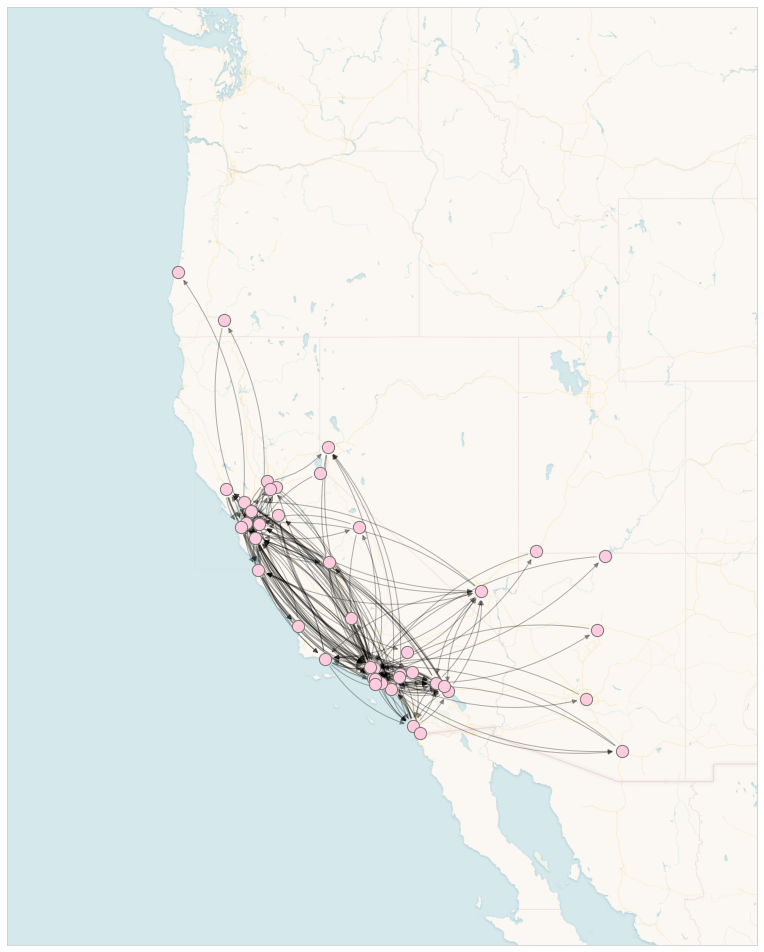

In [60]:
air_transport_network = create_network(air_network_ea, graph = 0)

In [61]:
air_transport_network

In [149]:
cluster = nx.average_clustering(air_transport_network)
avg_shortest_path = nx.average_shortest_path_length(air_transport_network)
length = len(air_transport_network.nodes())
average_degree = floor(np.mean(list(dict(air_transport_network.degree()).values())))

In [150]:
average_degree

11

In [151]:
#random graph comparison

random_graph = nx.watts_strogatz_graph(length, average_degree, p = 1, seed=None)
clustering_random = nx.average_clustering(random_graph)
avg_shortest_path_random = nx.average_shortest_path_length(random_graph)

print('Network Length for Regional Flight Network: ', len(air_transport_network.nodes()))
print('Network Length for Random Graph: ', len(random_graph.nodes()))

print('Num. Edges for Regional Flight Network: ', len(air_transport_network.edges()))
print('Num. Edges for Random Graph: ', len(random_graph.edges()))

print('Clustering Coefficient for Regional Flight Network: ', round(cluster, 3))
print('Clustering Coefficient for Random Graph: ', round(clustering_random, 3))

print('Average Shortest Path for Regional Flight Network: ', round(avg_shortest_path, 3))
print('Average Shortest Path for Random Graph: ', round(avg_shortest_path_random, 3))

Network Length for Regional Flight Network:  43
Network Length for Random Graph:  43
Num. Edges for Regional Flight Network:  247
Num. Edges for Random Graph:  215
Clustering Coefficient for Regional Flight Network:  0.433
Clustering Coefficient for Random Graph:  0.213
Average Shortest Path for Regional Flight Network:  1.894
Average Shortest Path for Random Graph:  1.812


In [173]:
# small world graph comparison

C_p = nx.average_clustering(air_transport_network)
C_0 = nx.average_clustering(nx.watts_strogatz_graph(len(air_transport_network.nodes()), average_degree, p = 0))
p = 1 - pow(C_p/C_0, 1/3)

small_world = nx.watts_strogatz_graph(length, average_degree, p, seed = None)
clustering_sw = nx.average_clustering(small_world)
avg_shortest_path_sw = nx.average_shortest_path_length(small_world)

print('Network Length for Regional Flight Network: ', len(air_transport_network.nodes()))
print('Network Length for Small World: ', len(small_world.nodes()))

print('Num. Edges for Regional Flight Network: ', len(air_transport_network.edges()))
print('Num. Edges for Small World: ', len(small_world.edges()))

print('Avg. Degree for New Network: ', average_degree)
average_degree_sw_1 = floor(np.mean(list(dict(small_world.degree()).values())))
print('Avg. Degree for Small World  Network: ', average_degree_sw_1)

print('Clustering Coefficient for Regional Flight Network: ', round(cluster, 3))
print('Clustering Coefficient for Small World: ', round(clustering_sw, 3))

print('Average Shortest Path for Regional Flight Network: ', round(avg_shortest_path, 3))
print('Average Shortest Path for Small World: ', round(avg_shortest_path_sw, 3))

Network Length for Regional Flight Network:  43
Network Length for Small World:  43
Num. Edges for Regional Flight Network:  247
Num. Edges for Small World:  215
Avg. Degree for New Network:  11
Avg. Degree for Small World  Network:  10
Clustering Coefficient for Regional Flight Network:  0.433
Clustering Coefficient for Small World:  0.514
Average Shortest Path for Regional Flight Network:  1.894
Average Shortest Path for Small World:  2.073


In [171]:
p

0.13386174427782427

In [195]:
# barabasi-albert (scale-free) model
scale_free = nx.barabasi_albert_graph(length, 11, seed = None)
clustering_sf = nx.average_clustering(scale_free)
avg_shortest_path_sf = nx.average_shortest_path_length(scale_free)

print('Network Length for Regional Flight Network: ', len(air_transport_network.nodes()))
print('Network Length for Scale Free Network: ', len(scale_free.nodes()))

print('Num. Edges for Regional Flight Network: ', len(air_transport_network.edges()))
print('Num. Edges for Scale Free Network: ', len(scale_free.edges()))

print('Avg. Degree for New Network: ', average_degree)
average_degree_sf_1 = floor(np.mean(list(dict(scale_free.degree()).values())))
print('Avg. Degree for Scale Free  Network: ', average_degree_sf_1)

print('Clustering Coefficient for Regional Flight Network: ', round(cluster, 3))
print('Clustering Coefficient for Scale Free Network: ', round(clustering_sf, 3))

print('Average Shortest Path for Regional Flight Network: ', round(avg_shortest_path, 3))
print('Average Shortest Path for Scale Free Network: ', round(avg_shortest_path_sf, 3))# barabasi-albert (scale-free) model


Network Length for Regional Flight Network:  43
Network Length for Scale Free Network:  43
Num. Edges for Regional Flight Network:  247
Num. Edges for Scale Free Network:  352
Avg. Degree for New Network:  11
Avg. Degree for Scale Free  Network:  16
Clustering Coefficient for Regional Flight Network:  0.433
Clustering Coefficient for Scale Free Network:  0.522
Average Shortest Path for Regional Flight Network:  1.894
Average Shortest Path for Scale Free Network:  1.61


In [197]:
prg = 2*247/(43*42)

In [198]:
random = nx.erdos_renyi_graph(43, prg, seed = None, directed = False)

print('Average clustering coefficient = ', nx.average_clustering(random))
print('Average shortest path length = ',nx.average_shortest_path_length(random))
print ("Number of nodes:" , random.number_of_nodes())
print ("Number of edges:" , random.number_of_edges())
print ("2*Edges/N:" , 2 * random.number_of_edges() / random.number_of_nodes())
print ("Average degree of  directed graph = ", np.mean(list(dict(random.degree()).values())))

Average clustering coefficient =  0.26057121173400244
Average shortest path length =  1.7895902547065339
Number of nodes: 43
Number of edges: 227
2*Edges/N: 10.55813953488372
Average degree of  directed graph =  10.55813953488372


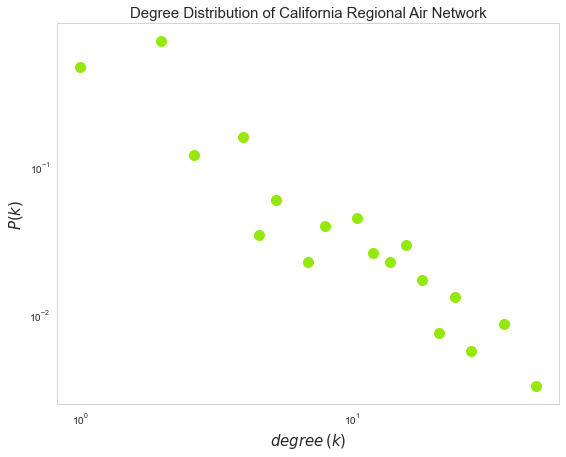

In [82]:
from matplotlib.ticker import FormatStrFormatter
degrees = dict(air_transport_network.degree())
degrees = list(degrees.values())

def remove_values_from_list(the_list, val):
    return [value for value in the_list if value != val]

degrees = remove_values_from_list(degrees,0)

fig, ax = plt.subplots()
fig.set_size_inches((9, 7))

n_bins = 30

#n, bins = np.histogram(out_d, bins = range(min(out_d), max(out_d)+1, 2), normed="True") 
logBins = np.logspace(np.log10(min(degrees)), np.log10(max(degrees)), num = n_bins)
logBinDensity, binedges = np.histogram(degrees, bins = logBins, density = True)

ax.loglog(logBins[:-1], logBinDensity,'o', markersize = 10, color = '#94e80c', label = r'$degree\,(k)$')
#ax.legend(fontsize = 13)

ax.set_xlabel('$degree\,(k)$',fontsize = 15);
ax.set_ylabel('$P(k)$',fontsize=15);
ax.set_title('Degree Distribution of California Regional Air Network', fontsize = 15);

#plt.savefig('Presentation Figures/degree_dist_original.png', transparent = False, bbox_inches = 'tight', pad_inches = 0, dpi = 300)



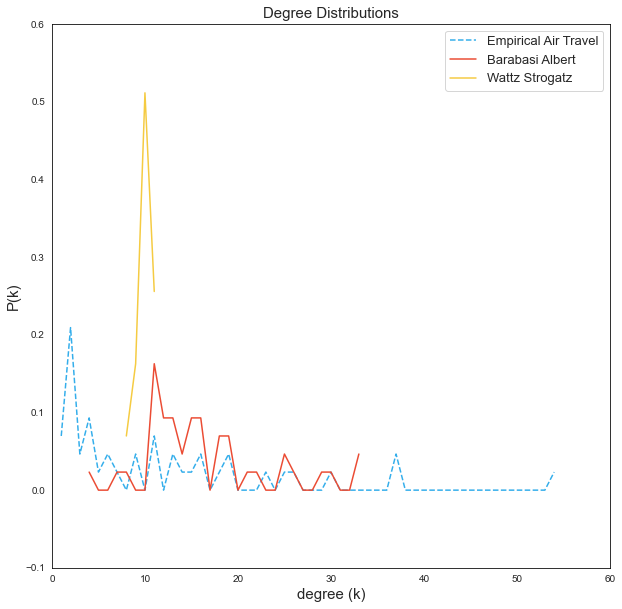

In [204]:
#G1:
degs1 = list(dict(nx.degree(air_transport_network)).values())
# degs1 = remove_values_from_list(degs1, 0)
n1, bins1 = np.histogram(degs1, bins = list(range(min(degs1), max(degs1)+1, 1)), density="True")

#G2:
degs2 = list(dict(nx.degree(scale_free)).values())
# degs2 = remove_values_from_list(degs2, 0)
n2, bins2 = np.histogram(degs2, bins = list(range(min(degs2), max(degs2)+1, 1)), density="True")

#G3:
degs3 = list(dict(nx.degree(small_world)).values())
# degs3 = remove_values_from_list(degs3,0)
n3, bins3 = np.histogram(degs3, bins = list(range(min(degs3), max(degs3)+1, 1)), density="True")

# #G4:
# degs4 = list(dict(nx.degree(random)).values())
# degs4 = remove_values_from_list(degs4,0)
# n4, bins4 = np.histogram(degs4, bins = list(range(min(degs4), max(degs4)+1, 1)), density="True")

plt.figure(figsize=(10,10)) #use once and set figure size
plt.plot(bins1[:-1], n1, '#34aeeb', markersize = 10, label = "Empirical Air Travel", linestyle = '--') 
plt.plot(bins2[:-1], n2, '#eb4c34', markersize = 10, label = "Barabasi Albert") 
plt.plot(bins3[:-1], n3, '#f5cb42', markersize = 10, label = "Wattz Strogatz") 
# plt.plot(bins4[:-1], n4, '#f54284', markersize = 10, label = "Erdos Renyi") 
plt.xlim([0, 60])
plt.ylim([-0.1, 0.6])
plt.rcParams["axes.edgecolor"] = "black"
plt.legend(loc = 'upper right', fontsize = 13)
plt.title('Degree Distributions', fontsize = 15)
plt.xlabel('degree (k)', fontsize = 15)
plt.ylabel('P(k)', fontsize = 15)
plt.savefig('Presentation Figures/degree_dists_comp_original.png', transparent = False, bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)
plt.show()

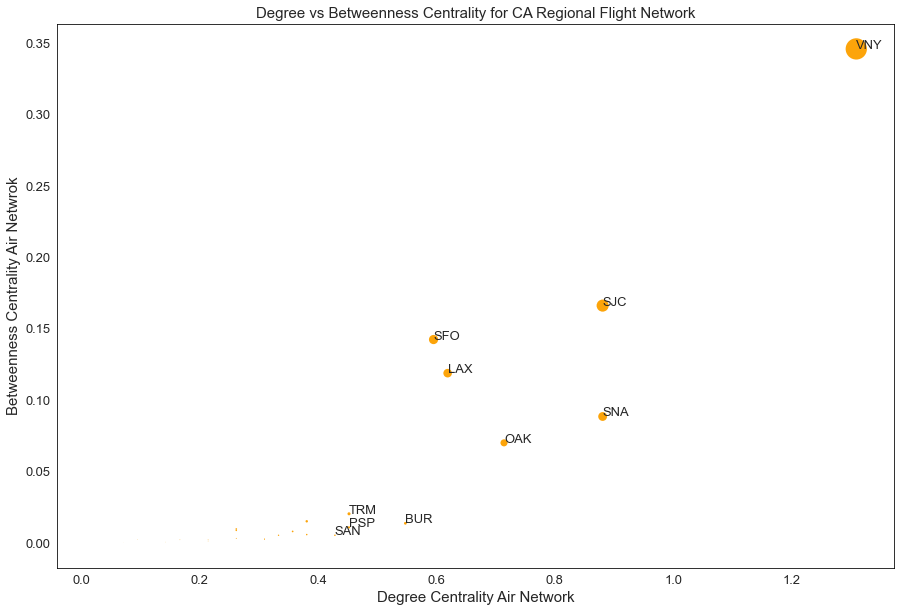

In [206]:
deg_centrality_air = nx.degree_centrality(air_transport_network)
bet_centrality_air = nx.betweenness_centrality(air_transport_network)

x = list(deg_centrality_air.values())
y = list(bet_centrality_air.values())
airport_labels = enumerate(list(deg_centrality_air.keys()))
s = np.multiply(x,y)*1e3
plt.figure(2, figsize=(15, 10))
sns.scatterplot(x,y,s = s, color = '#fca40a', edgecolor = 'black')
plt.xlabel('Degree Centrality Air Network', size = 15);
plt.ylabel('Betweenness Centrality Air Netwrok', size = 15);
plt.xticks(fontsize=13);
plt.yticks(fontsize=13);
plt.title('Degree vs Betweenness Centrality for CA Regional Flight Network', size = 15);
plt.rcParams["axes.edgecolor"] = "black"
for i, name in airport_labels:
    if deg_centrality_air[name] > 0.4 or bet_centrality_air[name] > 0.02:
        plt.annotate(name, (x[i], y[i]), size = 13)
plt.savefig('Presentation Figures/degree_between_original.png', transparent = False, bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)



# 7. Network Properties of Original Air Network and Converted Ground Commuting Routes

In [211]:
selected_routes = pd.concat([selected_set, airport_selected.set_index(selected_set.index)], axis = 1)

In [212]:
air_network_ea

,UID Route,OD Pair Name,Departure,Arrival,Num. of Flights,Cruise Time (min),Total Taxi/Idle (min),Fuel Consumption (kg/pax/mi),CO2 (kg/pax/mi),HC (kg/pax/mi),...,Common A/C Type,CO2 Community,Upper/Lower Half,Speed Ratio,Freq. Alice Equivalent,Freq. ZA Equivalent,Flight Hr. Coef,Num. Jet AC,EA EF (kg CO2 eq),ZA EF (kg CO2 eq)
0,APCBUR,APCBUR,APC,BUR,13,45.023077,16.423077,0.602458,1.898641,0.000226,...,C680,24.682328,1,2.090909,13.0,13.0,0.000653,0.003280,0.0436,0.982858
1,BURAPC,APCBUR,BUR,APC,20,49.200000,18.500000,0.661928,2.086049,0.000227,...,C680,41.720976,1,2.090909,20.0,20.0,0.000713,0.005514,0.4268,10.676103
2,LASAPC,APCLAS,LAS,APC,22,60.281818,21.181818,0.617314,1.945026,0.000643,...,C750,42.790573,1,2.400000,44.0,22.0,0.000960,0.007425,0.5470,11.423904
3,APCLAX,APCLAX,APC,LAX,18,49.322222,23.222222,0.663920,2.092508,0.000207,...,C680,37.665136,1,2.090909,36.0,18.0,0.000740,0.004982,0.0436,0.982858
4,LAXAPC,APCLAX,LAX,APC,36,51.711111,20.277778,0.539267,1.699771,0.000486,...,C680,61.191742,1,2.090909,72.0,36.0,0.000752,0.010433,0.3211,8.998574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,VNYTRM,TRMVNY,VNY,TRM,71,21.254930,17.697183,0.850974,2.684040,0.001249,...,G400,190.566866,1,2.152273,142.0,71.0,0.000391,0.008546,0.3211,8.998574
243,TUSVNY,TUSVNY,TUS,VNY,27,64.951852,16.981481,0.531516,1.675117,0.001426,...,C750,45.228168,1,2.400000,27.0,27.0,0.000999,0.009802,0.6119,15.599311
244,VNYTUS,TUSVNY,VNY,TUS,29,54.996552,17.224138,0.586232,1.848382,0.001392,...,C750,53.603087,1,2.400000,29.0,29.0,0.000867,0.008925,0.3211,8.998574
245,UDDVNY,UDDVNY,UDD,VNY,15,26.700000,17.300000,1.028595,3.241907,0.000558,...,C680,48.628612,1,2.090909,15.0,15.0,0.000445,0.002259,0.1298,3.775414


In [213]:
temp_air = air_network_ea[['Departure', 'Arrival', 'Dep Lat', 'Dep Lon', 'Arr Lat', 'Arr Lon']]
temp_air['Original'] = 1

In [214]:
fmerge = selected_routes.merge(ca_airports, left_on = 'Origin Airport', right_on = 'AIRPORTID').drop('AIRPORTID', axis = 1)
fmerge = fmerge.rename(columns = {'LATDD': 'Dep Lat', 'LONGDD': 'Dep Lon'})

smerge = fmerge.merge(ca_airports, left_on = 'Origin Airport', right_on = 'AIRPORTID').drop('AIRPORTID', axis = 1)
smerge = smerge.rename(columns = {'LATDD': 'Arr Lat', 'LONGDD': 'Arr Lon'})



In [215]:
temp_ground = smerge[['Origin Airport', 'Dest Airport', 'Dep Lat', 'Dep Lon', 'Arr Lat', 'Arr Lon']]
temp_ground = temp_ground.rename(columns = {'Origin Airport': 'Departure', 'Dest Airport': 'Arrival'})

In [216]:
temp_ground['Original'] = 0

In [217]:
new_network_df = pd.concat([temp_air, temp_ground])

In [249]:
new_network_df[new_network_df['Departure'] == 'SCK']

,Departure,Arrival,Dep Lat,Dep Lon,Arr Lat,Arr Lon,Original
84,SCK,LAX,37.894199,-121.237999,33.942501,-118.407997,1
133,SCK,OAK,37.894199,-121.237999,37.721298,-122.221001,1
198,SCK,SFO,37.894199,-121.237999,37.618999,-122.375000,1
200,SCK,SJC,37.894199,-121.237999,37.362598,-121.929001,1
202,SCK,SNA,37.894199,-121.237999,33.675701,-117.867996,1
204,SCK,VNY,37.894199,-121.237999,34.209801,-118.489998,1
42,SCK,LVK,37.894167,-121.238306,37.894167,-121.238306,0
43,SCK,CCR,37.894167,-121.238306,37.894167,-121.238306,0
44,SCK,MHR,37.894167,-121.238306,37.894167,-121.238306,0
45,SCK,HAF,37.894167,-121.238306,37.894167,-121.238306,0


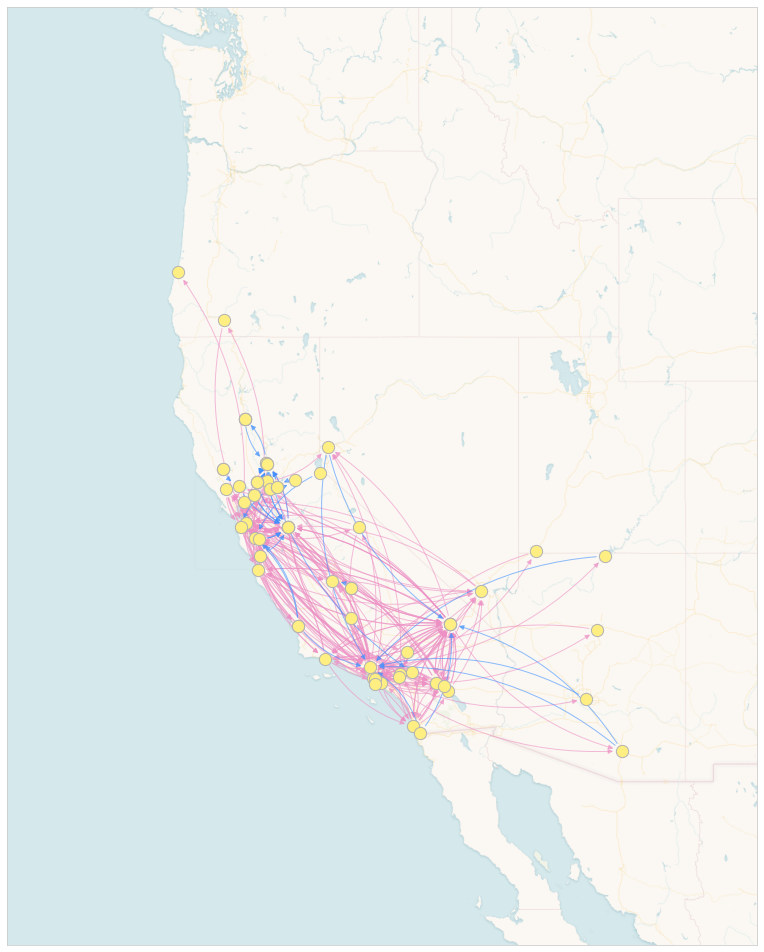

In [253]:
new_network = create_network(new_network_df.reset_index(drop = True), metric = 'Original', graph = 1)

In [138]:
new_network = new_network.to_undirected()
Gcc = sorted(nx.connected_components(new_network), key=len, reverse=True)
new_network_conn = new_network.subgraph(Gcc[0])

In [139]:
cluster = nx.average_clustering(new_network_conn.to_undirected())
avg_shortest_path = nx.average_shortest_path_length(new_network_conn)
length = len(new_network_conn.nodes())
average_degree = floor(np.mean(list(dict(new_network_conn.degree()).values())))

In [143]:
average_degree

5

In [147]:
p

0.12385579450071638

In [146]:
# small world graph comparison

C_p = nx.average_clustering(new_network_conn)
C_0 = nx.average_clustering(nx.watts_strogatz_graph(len(new_network_conn.nodes()), average_degree, p = 0))
p = 1 - (C_p / C_0)**(1/3)

small_world_2 = nx.watts_strogatz_graph(length, average_degree, p, seed=None)
clustering_sw_2 = nx.average_clustering(small_world_2)
avg_shortest_path_sw_2 = nx.average_shortest_path_length(small_world_2)

print('Network Length for New Network: ', len(new_network_conn.nodes()))
print('Network Length for Small World Network: ', len(small_world_2.nodes()))

print('Num. Edges for New Network: ', len(new_network_conn.edges()))
print('Num. Edges for Small World  Network: ', len(small_world_2.edges()))

print('Avg. Degree for New Network: ', average_degree)
average_degree_sw_2 = floor(np.mean(list(dict(small_world_2.degree()).values())))
print('Avg. Degree for Small World  Network: ', average_degree_sw_2)

print('Clustering Coefficient for New Network: ', round(cluster, 3))
print('Clustering Coefficient for Small World : ', round(clustering_sw_2, 3))

print('Average Shortest Path for New Network: ', round(avg_shortest_path, 3))
print('Average Shortest Path for Small World : ', round(avg_shortest_path_sw_2, 3))

Network Length for New Network:  70
Network Length for Small World Network:  70
Num. Edges for New Network:  190
Num. Edges for Small World  Network:  140
Avg. Degree for New Network:  5
Avg. Degree for Small World  Network:  4
Clustering Coefficient for New Network:  0.336
Clustering Coefficient for Small World :  0.343
Average Shortest Path for New Network:  3.059
Average Shortest Path for Small World :  4.05


In [145]:
p

0.12385579450071638

In [148]:
# barabasi-albert (scale-free) model
scale_free_2 = nx.barabasi_albert_graph(length, average_degree, seed = None)
clustering_sf_2 = nx.average_clustering(scale_free_2)
avg_shortest_path_sf_2 = nx.average_shortest_path_length(scale_free_2)

print('Network Length for New Network: ', len(new_network_conn.nodes()))
print('Network Length for Scale Free Network: ', len(scale_free_2.nodes()))

print('Num. Edges for New Network: ', len(new_network_conn.edges()))
print('Num. Edges for Scale Free Network: ', len(scale_free_2.edges()))

print('Avg. Degree for New Network: ', average_degree)
average_degree_sf_2 = floor(np.mean(list(dict(scale_free_2.degree()).values())))
print('Avg. Degree for Small World  Network: ', average_degree_sf_2)

print('Clustering Coefficient for New Network: ', round(cluster, 3))
print('Clustering Coefficient for Scale Free Graph: ', round(clustering_sf_2, 3))

print('Average Shortest Path for New Network: ', round(avg_shortest_path, 3))
print('Average Shortest Path for Scale Free Graph: ', round(avg_shortest_path_sf_2, 3))

Network Length for New Network:  70
Network Length for Scale Free Network:  70
Num. Edges for New Network:  190
Num. Edges for Scale Free Network:  325
Avg. Degree for New Network:  5
Avg. Degree for Small World  Network:  9
Clustering Coefficient for New Network:  0.336
Clustering Coefficient for Scale Free Graph:  0.218
Average Shortest Path for New Network:  3.059
Average Shortest Path for Scale Free Graph:  2.085


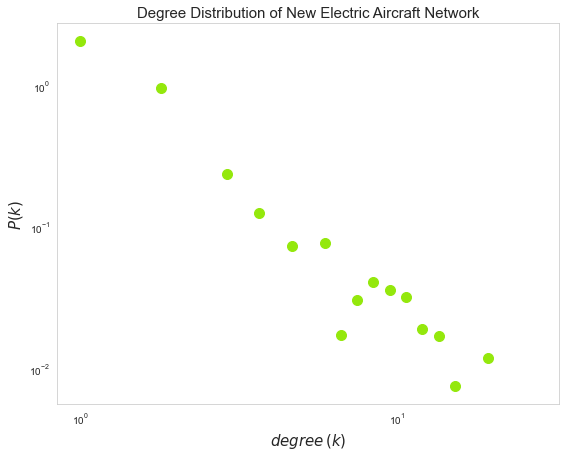

In [164]:
degrees = dict(new_network_conn.degree(weight = 'weight'))
degrees = list(degrees.values())

def remove_values_from_list(the_list, val):
    return [value for value in the_list if value != val]

degrees = remove_values_from_list(degrees,0)

fig, ax = plt.subplots()
fig.set_size_inches((9, 7))

n_bins = 30

#n, bins = np.histogram(out_d, bins = range(min(out_d), max(out_d)+1, 2), normed="True") 
logBins = np.logspace(np.log10(min(degrees)), np.log10(max(degrees)),num = n_bins)
logBinDensity, binedges = np.histogram(degrees, bins = logBins, density = True)

ax.loglog(logBins[:-1], logBinDensity,'o', markersize = 10, color = '#94e80c', label = r'$degree\,(k)$')
#ax.legend(fontsize = 13)

ax.set_xlabel('$degree\,(k)$',fontsize=15);
ax.set_ylabel('$P(k)$',fontsize=15);
ax.set_title('Degree Distribution of New Electric Aircraft Network', fontsize = 15);
plt.savefig('Presentation Figures/degree_dist_new.png', transparent = False, bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)


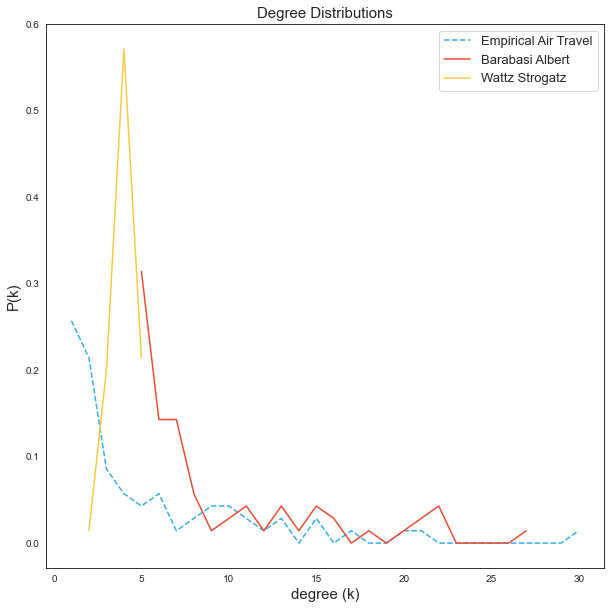

In [209]:
#G1:
degs1 = list(dict(nx.degree(new_network_conn)).values())
# degs1 = remove_values_from_list(degs1, 0)
n1, bins1 = np.histogram(degs1, bins = list(range(min(degs1), max(degs1)+1, 1)), density="True")

#G2:
degs2 = list(dict(nx.degree(scale_free_2)).values())
# degs2 = remove_values_from_list(degs2, 0)
n2, bins2 = np.histogram(degs2, bins = list(range(min(degs2), max(degs2)+1, 1)), density="True")

#G3:
degs3 = list(dict(nx.degree(small_world_2)).values())
# degs3 = remove_values_from_list(degs3,0)
n3, bins3 = np.histogram(degs3, bins = list(range(min(degs3), max(degs3)+1, 1)), density="True")

# #G4:
# degs4 = list(dict(nx.degree(random)).values())
# degs4 = remove_values_from_list(degs4,0)
# n4, bins4 = np.histogram(degs4, bins = list(range(min(degs4), max(degs4)+1, 1)), density="True")

plt.figure(figsize=(10,10)) #use once and set figure size
plt.plot(bins1[:-1], n1, '#34aeeb', markersize = 10, label = "Empirical Air Travel", linestyle = '--') 
plt.plot(bins2[:-1], n2, '#eb4c34', markersize = 10, label = "Barabasi Albert") 
plt.plot(bins3[:-1], n3, '#f5cb42', markersize = 10, label = "Wattz Strogatz") 
# plt.plot(bins4[:-1], n4, '#f54284', markersize = 10, label = "Erdos Renyi") 
# plt.xlim([0, 60])
# plt.ylim([-0.1, 0.6])
plt.rcParams["axes.edgecolor"] = "black"
plt.legend(loc = 'upper right', fontsize = 13)
plt.title('Degree Distributions', fontsize = 15)
plt.xlabel('degree (k)', fontsize = 15)
plt.ylabel('P(k)', fontsize = 15)
plt.savefig('Presentation Figures/degree_dists_comp_new.png', transparent = False, bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)
plt.show()

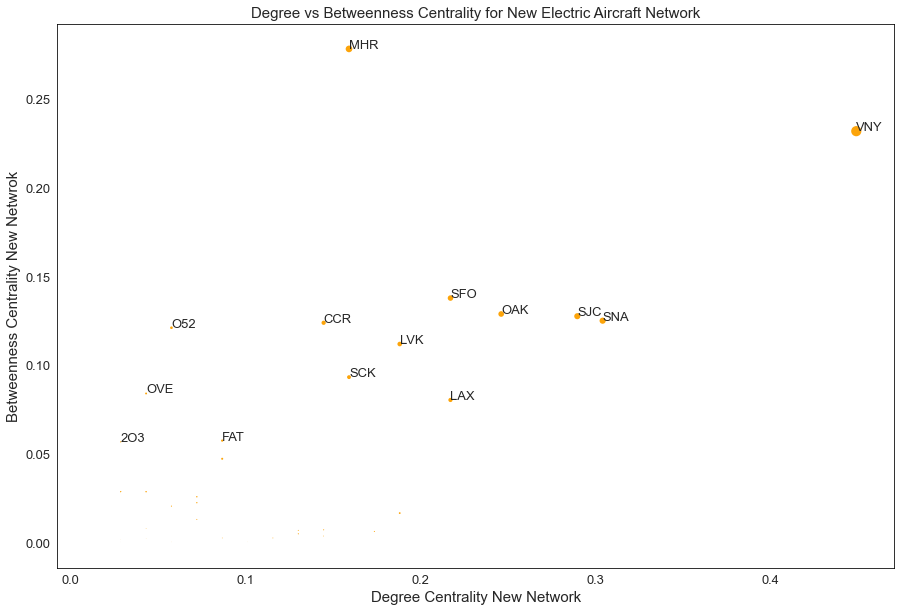

In [210]:
deg_centrality_new = nx.degree_centrality(new_network_conn)
bet_centrality_new = nx.betweenness_centrality(new_network_conn)

x = list(deg_centrality_new.values())
y = list(bet_centrality_new.values())
airport_labels = enumerate(list(deg_centrality_new.keys()))
s = np.multiply(x,y)*1e3
plt.figure(2, figsize=(15, 10))
sns.scatterplot(x,y,s = s, color = '#fca40a', edgecolor = 'black')
plt.xlabel('Degree Centrality New Network', size = 15);
plt.ylabel('Betweenness Centrality New Netwrok', size = 15);
plt.xticks(fontsize=13);
plt.yticks(fontsize=13);
plt.title('Degree vs Betweenness Centrality for New Electric Aircraft Network', size = 15);
plt.rcParams["axes.edgecolor"] = "black"
for i, name in airport_labels:
    if deg_centrality_new[name] > 0.4 or bet_centrality_new[name] > 0.05:
        plt.annotate(name, (x[i], y[i]), size = 13)
plt.savefig('Presentation Figures/degree_between_new.png', transparent = False, bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

